<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/main/Pneumonia_Identifier_Using_Chest_XRay_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:58<00:00, 52.6MB/s]
100% 2.29G/2.29G [00:58<00:00, 42.4MB/s]


In [ ]:
! mkdir ./data
! unzip chest-xray-pneumonia.zip -d ./data > extract.log
! rm -rf chest-xray-pneumonia.zip

In [167]:
import os
import numpy as np
import torch
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as mtr

import torch
from torchvision.transforms import ToTensor
from torchvision.models import resnet18

In [ ]:
class chest_xray_data(object):

  def __init__(self, root, split, transforms=None):
    self.root = root
    self.transforms = transforms
    self.data_dir = os.path.join(root, split)
    self.imgs = [(i, 'NORMAL') for i in list(sorted(os.listdir(os.path.join(self.data_dir, 'NORMAL'))))]
    self.imgs += [(i, 'PNEUMONIA') for i  in list(sorted(os.listdir(os.path.join(self.data_dir, 'PNEUMONIA'))))]

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img_path = os.path.join(self.data_dir, self.imgs[idx][1], self.imgs[idx][0])
    img = Image.open(img_path).convert('RGB').resize((448, 448))
    img = np.moveaxis(np.array(img)/255.0, -1, 0)
    label = 0 if self.imgs[idx][1] == 'NORMAL' else 1
    if self.transforms is not None:
      img, label = self.transforms(img, label)
    return img, label


In [ ]:
train_data = chest_xray_data('/content/data/chest_xray', 'train')
test_data = chest_xray_data('/content/data/chest_xray', 'test')

In [60]:
train_dataloader = torch.utils.data.DataLoader(train_data, 64, True)
test_dataloader = torch.utils.data.DataLoader(test_data, 64, True)

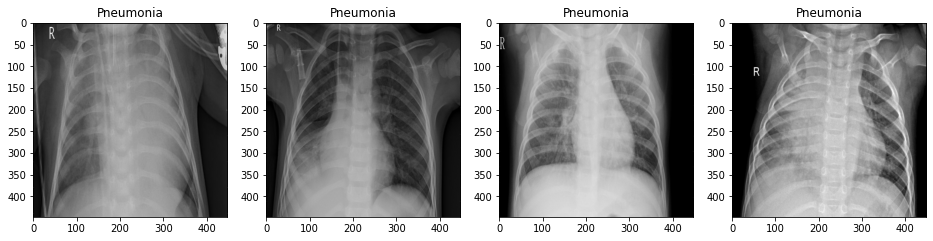

In [61]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for i in train_dataloader:
  for j in range(4):
    img = i[0][j]
    label = i[1][j]
    ax[j].imshow(np.moveaxis(img.numpy(), 0, -1))
    ax[j].set_title('Normal' if label == 0 else 'Pneumonia')
  break

In [76]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    
    pred = model(X.float())
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % int(size/10) == 0:
      loss, current = loss.item(), batch
      print(f"loss: {loss:>7f}  [{current:>2d}/{size:>2d}]")

In [77]:
def test(dataloader, model):
  size = len(dataloader.dataset)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X.float())
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n")

In [78]:
model = resnet18(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
in_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 32),
    torch.nn.BatchNorm1d(32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 2),
    torch.nn.Sigmoid()
)
#model.fc = torch.nn.Linear(in_features, 2)

In [82]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-4, momentum=0.9, weight_decay=0.0005)
loss_fn = torch.nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else  'cpu'
num_epochs = 10
print(f"Model Is Running On {device}")

Model Is Running On cuda


In [80]:
test(test_dataloader, model.to(device))

Test Error: 
 Accuracy: 37.5%, Avg loss:0.011209 



In [83]:
for i in range(num_epochs):
  print(f"Epoch {i+1}\n-------------------------------")
  train(train_dataloader, model.to(device), loss_fn, optimizer)
  test(test_dataloader, model.to(device))

Epoch 1
-------------------------------
loss: 0.415480  [ 0/82]
loss: 0.407572  [ 8/82]
loss: 0.424811  [16/82]
loss: 0.426156  [24/82]
loss: 0.396393  [32/82]
loss: 0.447366  [40/82]
loss: 0.387852  [48/82]
loss: 0.409892  [56/82]
loss: 0.422562  [64/82]
loss: 0.397395  [72/82]
loss: 0.395400  [80/82]
Test Error: 
 Accuracy: 86.4%, Avg loss:0.007655 

Epoch 2
-------------------------------
loss: 0.412903  [ 0/82]


KeyboardInterrupt: ignored

In [158]:
pred = list()
true = list()
with torch.no_grad():
  model.to(device)
  for X, y in test_dataloader:
    true.append(y)
    y_pred = model(X.float().to(device))
    pred.append(y_pred)

In [159]:
pred = np.argmax(np.array([tuple(j) for i in pred for j in i.to('cpu').numpy()]),axis=1)
true = np.array([j for i in true for j in i.numpy()])

Precision Score : 83.624454
Recall Score : 98.205128


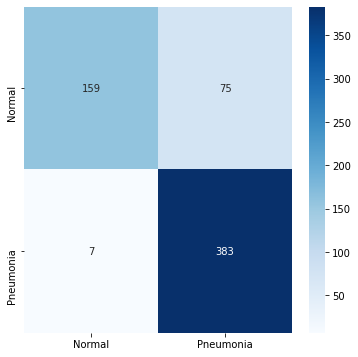

In [187]:
conf = mtr.confusion_matrix(true, pred)
print(f'Precision Score : {mtr.precision_score(true, pred)*100:3f}')
print(f'Recall Score : {mtr.recall_score(true, pred)*100:3f}')
fig,ax = plt.subplots(figsize=(6,6))
fig = sns.heatmap(conf, annot=True, fmt='.4g', xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'], ax=ax, cmap='Blues')

In [192]:
torch.save(model.state_dict(), 'chest_xray_model.pth')